In [1]:
#Imports 

import praw
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_curve, auc


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier


from wordcloud import WordCloud

### Gathering data from Reddit

In [3]:
# Instantiate Praw

reddit = praw.Reddit(
    client_id='-------------------',
    client_secret='------------------',
    user_agent='--------------------',
    username='------------------',
    password= '------------------'
)

In [ ]:
# Pull in some reddit posts from r/NFL. Reddit has an API limit somewhere around 100 posts, but
# I'm going to try and get by it and see what happens if I try and pull 1000


subreddit_nfl = reddit.subreddit("NFL")
posts = subreddit_nfl.new(limit=1000)
data_nfl = []
for post in posts:
    data_nfl.append([post.created_utc, post.title, post.selftext, post.subreddit])

subreddit_cfb = reddit.subreddit("cfb")
posts = subreddit_cfb.new(limit=1000)
data_cfb = []
for post in posts:
    data_cfb.append([post.created_utc, post.title, post.selftext, post.subreddit])

In [ ]:
# Create a dataframe and export them as .csv to save my work

nfl = pd.DataFrame(data_nfl, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
cfb = pd.DataFrame(data_cfb, columns = ['created_utc', 'title', 'self_text', 'subreddit'])

In [ ]:
nfl.to_csv('nfl.csv')
cfb.to_csv('cfb.csv')

In [ ]:
# Repeat with 'top' posts

subreddit_nfl = reddit.subreddit("NFL")
posts = subreddit_nfl.top(limit=1000)
data_nfl = []
for post in posts:
    data_nfl.append([post.created_utc, post.title, post.selftext, post.subreddit])

subreddit_cfb = reddit.subreddit("cfb")
posts = subreddit_cfb.top(limit=1000)
data_cfb = []
for post in posts:
    data_cfb.append([post.created_utc, post.title, post.selftext, post.subreddit])

In [ ]:
cfb_new = pd.DataFrame(data_cfb, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
nfl_new = pd.DataFrame(data_nfl, columns = ['created_utc', 'title', 'self_text', 'subreddit'])

In [ ]:
merged_cfb = pd.concat([cfb, cfb_new], ignore_index=True)
merged_nfl = pd.concat([nfl, nfl_new], ignore_index=True)

In [ ]:
# Use the time stamp to check for duplicate posts. This number appears to be so precise that 
# it is unlikely two separate posts were actually posted at the same time. Far more likely is 
# that I pulled duplicates.

merged_nfl['created_utc'].value_counts()

In [ ]:
merged_cfb['created_utc'].value_counts()

In [ ]:
# Drop duplicate posts

merged_nfl = merged_nfl.drop_duplicates(subset=['created_utc'], keep='first')
merged_cfb = merged_cfb.drop_duplicates(subset=['created_utc'], keep='first')

In [ ]:
# Overwrite my original DataFrame with the merged and deduplicated DataFrame then export to .csv

cfb = merged_cfb
nfl = merged_nfl

In [ ]:
cfb.to_csv('cfb.csv')
nfl.to_csv('nfl.csv')

In [ ]:
# This process of pulling 'new', 'hot', or 'top' posts can be repeated as many times as necessary,
# it was quite a few for me, until you have a satisfactory number of unique posts. Be mindful, 
# however, to not overwrite your variables before saving your work by exporting to a csv.

### EDA

In [52]:
cfb = pd.read_csv('./cfb.csv')
nfl = pd.read_csv('./nfl.csv')

In [54]:
# Create a merged DataFrame for my subreddits

posts = pd.concat([nfl, cfb],ignore_index=True)
posts.shape

(4167, 5)

In [56]:
# Create a working DataFrame that concatenatest the title and self_text columns to perform analysis on both.

posts_concat = posts.copy()

posts_concat['text'] = posts_concat['title'].fillna('') + ' ' + posts_concat['self_text'].fillna('')

posts_concat.head()

,Unnamed: 0,created_utc,title,self_text,subreddit,text
0,0,1.732024e+09,Jordan Love has been intercepted in each of hi...,Love’s eight consecutive games with an INT is ...,nfl,Jordan Love has been intercepted in each of hi...
1,1,1.732024e+09,The Marching Ravens have evolved — but the man...,NaN,nfl,The Marching Ravens have evolved — but the man...
2,2,1.732024e+09,"[ESPN] Week 12 NFL Power Rankings: 1-32 poll, ...",NaN,nfl,"[ESPN] Week 12 NFL Power Rankings: 1-32 poll, ..."
3,3,1.732023e+09,[Yahoo!] NFL Power Rankings entering Week 12: ...,NaN,nfl,[Yahoo!] NFL Power Rankings entering Week 12: ...
4,4,1.732020e+09,"[NPS] Week 12 playoff scenarios. Giants, Titan...",NaN,nfl,"[NPS] Week 12 playoff scenarios. Giants, Titan..."


In [58]:
# Convert my object class to numeric.

posts_concat['subreddit'] = posts_concat['subreddit'].map({'nfl':1, 'CFB':0})

In [60]:
posts_concat.to_csv('./merged_posts.csv')

In [62]:
X = posts_concat['text']
y = posts_concat['subreddit']

y.value_counts()

subreddit
1    2125
0    2042
Name: count, dtype: int64

In [64]:
# First I used CountVectorizer to transform my data.

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state=42)

cvec = CountVectorizer(stop_words='english')

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [66]:
# Next I instantiated a NaiveBayes classifier and fit it on my count-vectorized data. 

nb = MultinomialNB()

nb.fit(X_train_cvec, y_train)

MultinomialNB()

In [68]:
# I acheived decent accuracy scores here, but I think I can do better. I am going to run a gridsearch to find the best hyperparameters.

nb.score(X_train_cvec, y_train), nb.score(X_test_cvec, y_test)

(0.97216, 0.935700575815739)

### Naive Bayes

In [70]:
X = posts_concat['text']
y = posts_concat['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state=42)

pipe = Pipeline([('cvec', CountVectorizer()),
                ('nb', MultinomialNB())])

pipe_params = { 
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words' : ['english']}

gs = GridSearchCV(
    pipe,
    pipe_params, 
    cv=5)


In [72]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': ['english']})

In [74]:
gs.best_params_

{'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}

In [76]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9968, 0.9596928982725528)

In [78]:
# I don't think we are going to beat these scores, but I am going to try some other classification models. 

In [112]:
preds = gs.predict(X_test)

### Logistic Regression

In [80]:
pipe = Pipeline([
    ('cvec', CountVectorizer(ngram_range = (1,3), stop_words='english')),
    ('logreg', LogisticRegression(penalty = 'l1', solver='saga', max_iter=5000))
])

pipe.fit(X_train, y_train)

pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.96608, 0.9309021113243762)

In [ ]:
# These scores are good and better than another iteration with 'Ridge' regularization, but NB is still better.

### Suppport Vector Machines

In [82]:
pipe = Pipeline([
    ('cvec', CountVectorizer(ngram_range=(1,3), stop_words='english')),
    ('svc', SVC(kernel='linear'))
])

pipe.fit(X_train, y_train)

pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.99968, 0.944337811900192)

In [ ]:
# Very good, but not as good as NB.

### Random Forests

In [84]:
cvec = CountVectorizer(stop_words='english')

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

rf = RandomForestClassifier(n_estimators = 500,
                           oob_score = True,
                           random_state = 42)

rf.fit(X_train_cvec, y_train)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)

In [86]:
rf.score(X_train_cvec, y_train), rf.score(X_test_cvec, y_test)

(0.99968, 0.9261036468330134)

In [ ]:
# Acheiving really fantastic accuracy with our training data, but overfit. I will try a randomized search to birng shrink that margin, but I don't 
# think that we are going to do much better than naive bayes

In [88]:
# Code supplied by Matt Brems in General Assembly DSB 1015

p = X_train_cvec.shape[1]

params = {
    'max_features': np.arange(1, p+1), 
    'max_depth': np.append(np.arange(1,9), None), 
    'min_samples_leaf': np.arange(1, 31) }

rf = RandomForestClassifier(n_estimators=100,
                            oob_score = True,
                            random_state=42)

rs = RandomizedSearchCV(rf, 
                        param_distributions=params,
                        n_iter=50, 
                        cv=5, 
                        n_jobs=8)

In [90]:
rs.fit(X_train_cvec, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=42),
                   n_iter=50, n_jobs=8,
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, None], dtype=object),
                                        'max_features': array([    1,     2,     3, ..., 17133, 17134, 17135]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])})

In [92]:
rs.score(X_train_cvec, y_train), rs.score(X_test_cvec, y_test)

(0.93344, 0.8905950095969289)

In [ ]:
# NB is still the way to go

### Looking at the most common unigrams and bigrams

In [94]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(posts_concat['text'])

text_transformed = cvec.transform(posts_concat['text'])

text_df = pd.DataFrame(
    text_transformed.toarray(),
    columns=cvec.get_feature_names_out())

In [96]:
# 15 most common unigrams

text_df.sum(axis=0).sort_values(ascending=False).head(15)

com            3171
game           2603
https          2588
state          2289
team           1854
undisclosed    1633
field          1594
thread         1561
football       1458
injury         1431
10             1407
espn           1379
cfb            1248
season         1198
week           1177
dtype: int64

In [98]:
text_df['subreddit'] = posts_concat['subreddit']
nfl_vector = text_df[text_df['subreddit']==1]
cfb_vector = text_df[text_df['subreddit']!=1]

In [100]:
# Top 25 words in NFL (ignoring 'subreddit')
nfl_vector.sum().sort_values(ascending=False).head(26)

subreddit    2125
nfl           851
https         693
game          637
com           612
team          530
highlight     507
week          458
comments      438
td            427
yards         412
season        347
espn          346
2024          336
qb            313
yd            311
10            298
time          291
field         288
games         254
11            248
pass          236
just          232
year          220
win           215
play          212
dtype: int64

In [102]:
# Top 25 in CFB
cfb_vector.sum().sort_values(ascending=False).head(25)

com             2559
state           2273
game            1966
https           1895
undisclosed     1633
thread          1447
injury          1344
football        1336
team            1324
field           1306
cfb             1247
10              1109
espn            1033
college          983
http             979
dealing          888
11               882
season           851
www              826
12               825
texas            787
nov              779
2024             756
questionable     725
teams            723
dtype: int64

In [104]:
# Most common bigrams

cvec = CountVectorizer(stop_words = 'english',
                      ngram_range = (2,2))

cvec.fit(posts_concat['text'])

bi_text_transformed = cvec.transform(posts_concat['text'])

bi_text_df = pd.DataFrame(
    bi_text_transformed.toarray(),
    columns=cvec.get_feature_names_out())

bi_text_df.sum(axis=0).sort_values(ascending=False).head(10)

college football            807
uncertain field             715
dealing undisclosed         692
redditcfb com               678
game thread                 656
undisclosed injury          650
espn com                    633
questionable undisclosed    596
injury uncertain            580
com college                 573
dtype: int64

In [106]:
# Top bigrams in NFL 

cvec = CountVectorizer(stop_words = 'english',
                      ngram_range = (2,2))

cvec.fit(posts_concat['text'])

bi_text_transformed = cvec.transform(posts_concat['text'])

bi_text_df = pd.DataFrame(
    bi_text_transformed.toarray(),
    columns=cvec.get_feature_names_out())

bi_text_df['subreddit'] = posts_concat['subreddit']

bi_nfl_vector = bi_text_df[bi_text_df['subreddit']==1]

bi_nfl_vector.sum(axis=0).sort_values(ascending=False).head(11)

subreddit       2125
espn com         246
nfl comments     213
field goal       177
com motion       170
media video      170
video cdn        170
https media      170
cdn espn         170
https www        149
motion 2024      140
dtype: int64

In [108]:
# Top bigrams in CFB

cvec = CountVectorizer(stop_words = 'english',
                      ngram_range = (2,2))

cvec.fit(posts_concat['text'])

bi_text_transformed = cvec.transform(posts_concat['text'])

bi_text_df = pd.DataFrame(
    bi_text_transformed.toarray(),
    columns=cvec.get_feature_names_out())

bi_text_df['subreddit'] = posts_concat['subreddit']

bi_cfb_vector = bi_text_df[bi_text_df['subreddit']==1]

bi_cfb_vector.sum(axis=0).sort_values(ascending=False).head(11)

subreddit       2125
espn com         246
nfl comments     213
field goal       177
com motion       170
media video      170
video cdn        170
https media      170
cdn espn         170
https www        149
motion 2024      140
dtype: int64

### Data Visualization

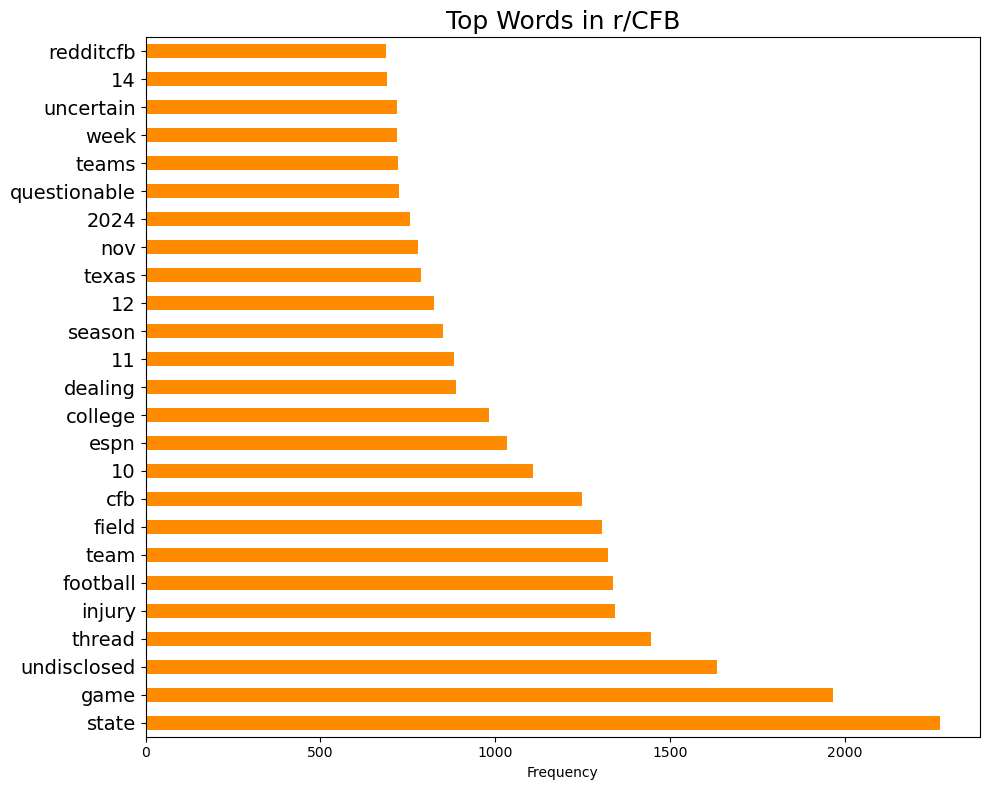

In [289]:
top_cfb_words = cfb_vector.drop(columns=['com', 'http', 'https', 'www']).sum().sort_values(ascending=False).head(25)
top_nfl_words = nfl_vector.drop(columns=['subreddit', 'http', 'https', 'com', 'wwws']).sum().sort_values(ascending=False).head(25)

plt.figure(figsize=(10, 8))
top_cfb_words.plot(kind='barh', color='darkorange')
plt.title('Top Words in r/CFB', fontsize = 18)
#plt.ylabel('Frequency')
plt.yticks(fontsize=14)
plt.xlabel('Frequency')
#plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


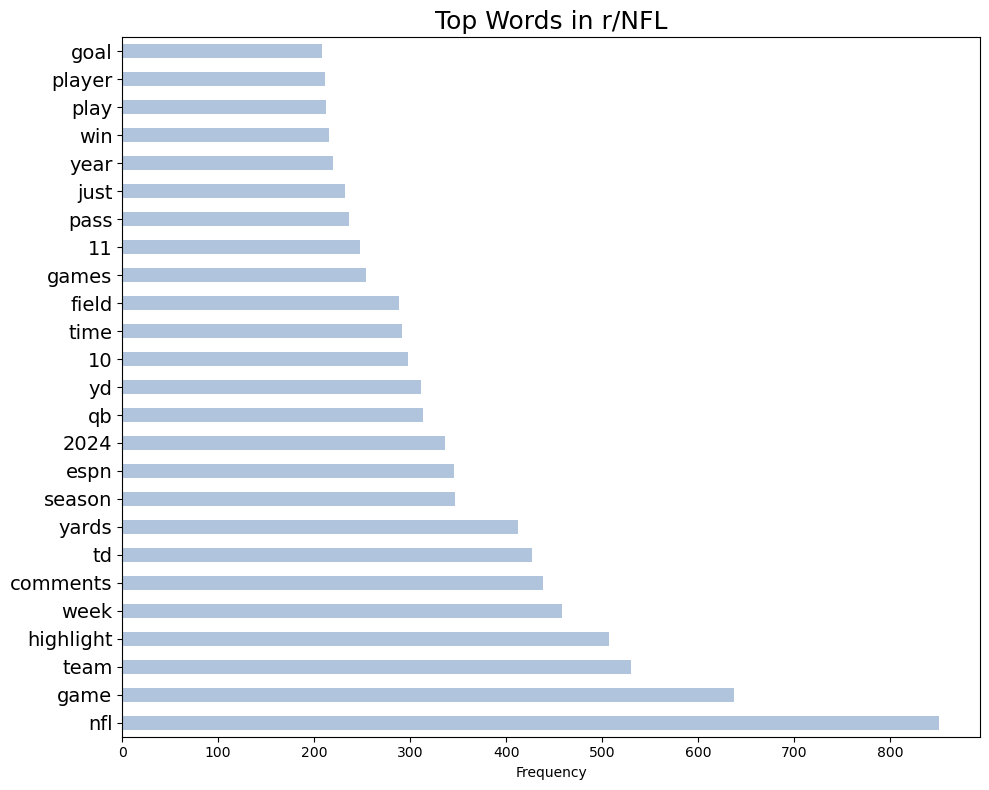

In [291]:
plt.figure(figsize=(10, 8))
top_nfl_words.plot(kind='barh', color='lightsteelblue')
plt.title('Top Words in r/NFL', fontsize = 18)
#plt.ylabel('Frequency')
plt.xlabel('Frequency')
plt.yticks(fontsize = 14)
#plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

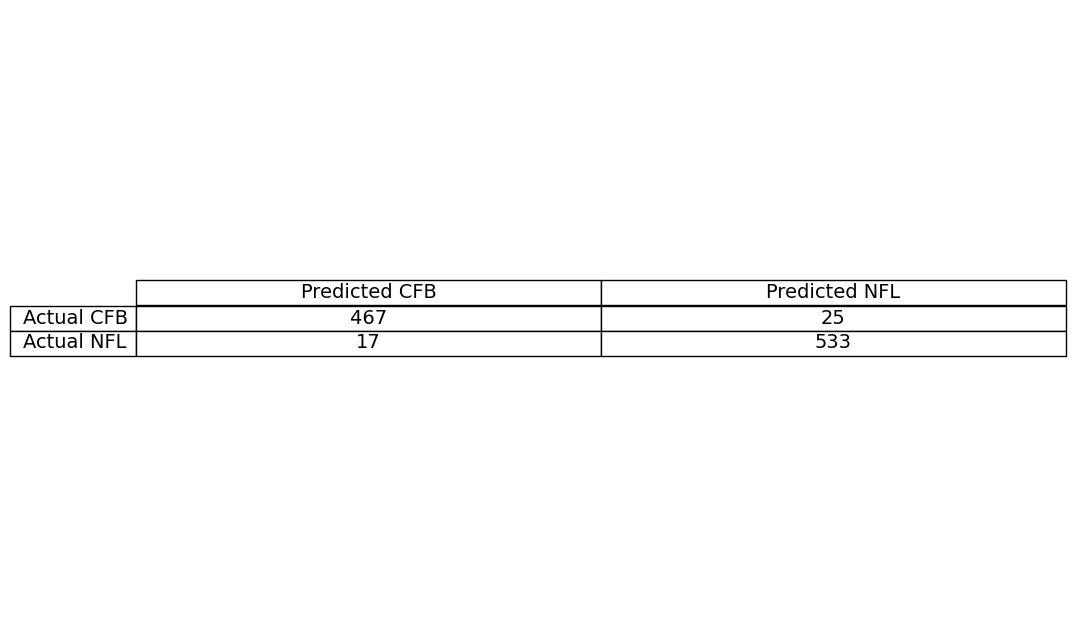

In [139]:
cm = confusion_matrix(y_test, preds, labels=[0, 1])

# Create a plot to display the table
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed
ax.axis('off')  # Hide axes

# Create table from confusion matrix
table_data = [['True CFB', 'False NFL'], ['False CFB', 'True NFL']]  # Table header
table_data[0][0] = cm[0, 0]  # True positive CFB
table_data[0][1] = cm[0, 1]  # False negative NFL
table_data[1][0] = cm[1, 0]  # False positive CFB
table_data[1][1] = cm[1, 1]  # True positive NFL

# Plot table
table = ax.table(cellText=table_data, colLabels=['Predicted CFB', 'Predicted NFL'],
                rowLabels=['Actual CFB', 'Actual NFL'], loc='center', cellLoc='center')

# Customize table aesthetics
table.auto_set_font_size(False)
table.set_fontsize(14)  # Adjust font size
table.scale(1.5, 1.5)  # Scale the table (width, height)

# Display the table
#plt.title("Confusion Matrix as Table", fontsize=16)
plt.show()

In [119]:
vectorizer = gs.best_estimator_.named_steps['cvec']
nb_model = gs.best_estimator_.named_steps['nb']

# Get feature names and log probabilities
feature_names = vectorizer.get_feature_names_out()
log_prob = nb_model.feature_log_prob_

# Top words for each class
n_top = 10
top_nfl = [feature_names[i] for i in log_prob[1].argsort()[-n_top:]]
top_cfb = [feature_names[i] for i in log_prob[0].argsort()[-n_top:]]

print("Top r/NFL words:", top_nfl)
print("Top r/CFB words:", top_cfb)

Top r/NFL words: ['yards', 'td', 'week', 'team', 'comments', 'highlight', 'game', 'com', 'https', 'nfl']
Top r/CFB words: ['thread', 'field', 'team', 'football', 'injury', 'undisclosed', 'game', 'https', 'state', 'com']


In [260]:
vectorizer = gs.best_estimator_.named_steps['cvec']
nb_model = gs.best_estimator_.named_steps['nb']

# Get feature names and log probabilities
feature_names = vectorizer.get_feature_names_out()
log_prob = nb_model.feature_log_prob_

# Words to exclude
exclude_words = ['http', 'https', 'com']

# Define number of top words to retrieve (ensure this is not larger than the number of features)
n_top = min(10, len(feature_names))  # Ensure we don't request more than available features

# Top words for each class
top_nfl_indices = log_prob[1].argsort()[-n_top:]  # NFL words
top_cfb_indices = log_prob[0].argsort()[-n_top:]  # CFB words

# Retrieve top words based on sorted indices
top_nfl = [feature_names[i] for i in top_nfl_indices]
top_cfb = [feature_names[i] for i in top_cfb_indices]

# Filter out the unwanted words
top_nfl_filtered = [word for word in top_nfl if word not in exclude_words]
top_cfb_filtered = [word for word in top_cfb if word not in exclude_words]

print("Top r/NFL words (filtered):", top_nfl_filtered)
print("Top r/CFB words (filtered):", top_cfb_filtered)

Top r/NFL words (filtered): ['yards', 'td', 'week', 'team', 'comments', 'highlight', 'game', 'nfl']
Top r/CFB words (filtered): ['thread', 'field', 'team', 'football', 'injury', 'undisclosed', 'game', 'state']


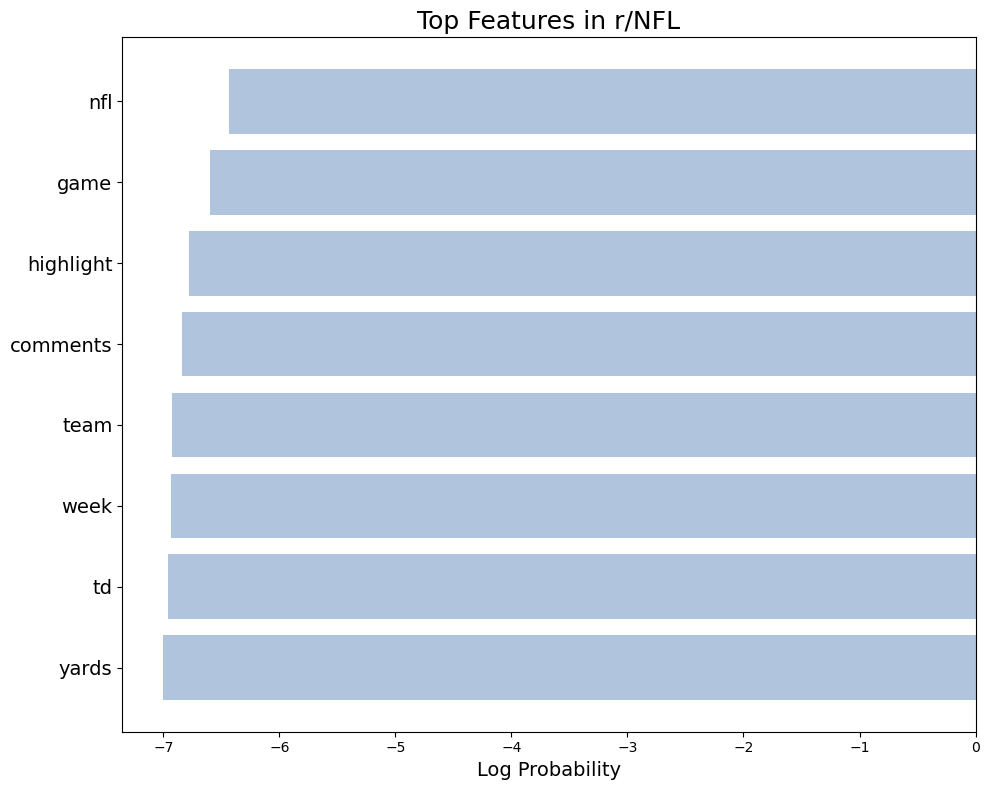

In [284]:
plt.figure(figsize=(10, 8))
plt.barh(top_nfl_filtered, nb_model.feature_log_prob_[1][top_nfl_indices][-len(top_nfl_filtered):], color='lightsteelblue')
plt.title('Top Features in r/NFL', fontsize=18)
plt.xlabel('Log Probability', fontsize=14)
#plt.ylabel('Words', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()



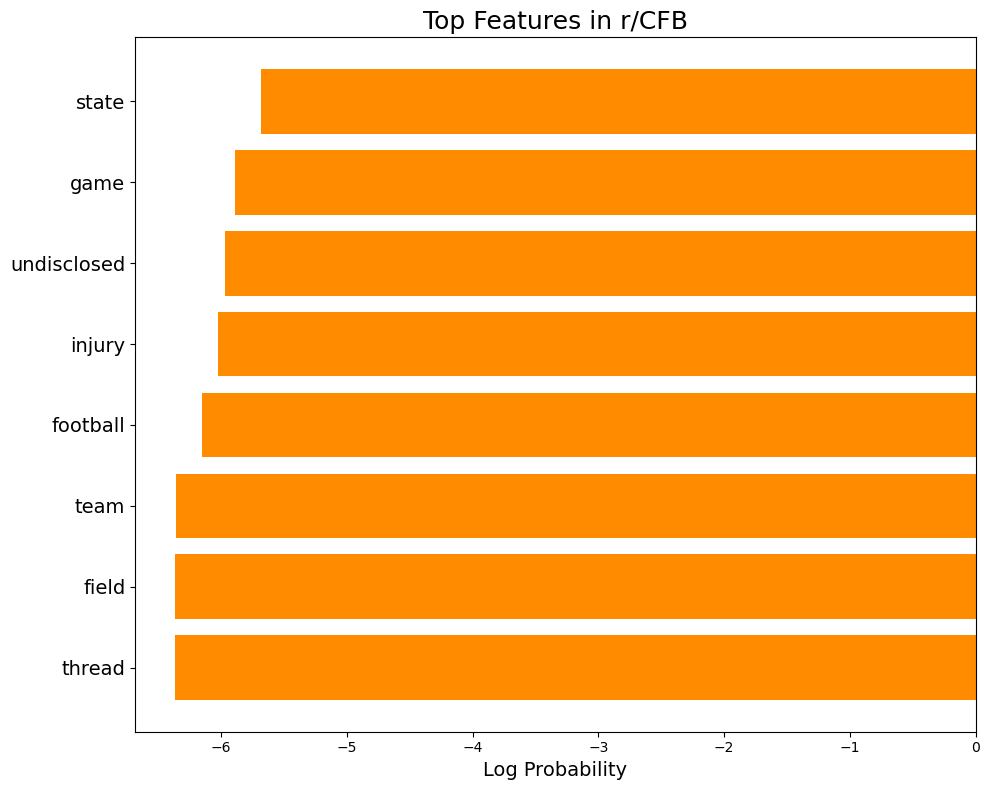

In [282]:
# Plot filtered top words for r/CFB
plt.figure(figsize=(10, 8))
plt.barh(top_cfb_filtered, nb_model.feature_log_prob_[0][top_cfb_indices][-len(top_cfb_filtered):], color='darkorange')
plt.title('Top Features in r/CFB', fontsize=18)
plt.xlabel('Log Probability', fontsize=14)
#plt.ylabel('Words', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

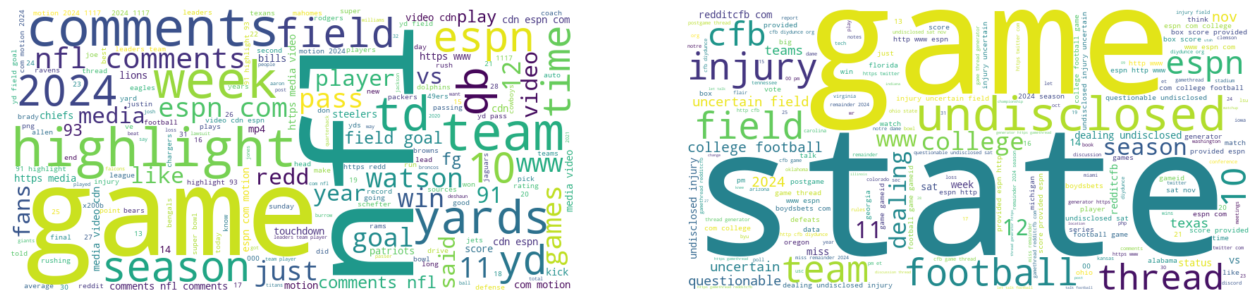

In [144]:
# Word clouds generated with help from Chat GPT and Stack Exchange
# https://stackoverflow.com/questions/44750574/creating-wordcloud-using-python

exclude_words = {'http', 'https', 'com'}

nfl_freq = {feature_names[i]: np.exp(log_prob[1, i]) 
            for i in range(len(feature_names)) if feature_names[i] not in exclude_words}

cfb_freq = {feature_names[i]: np.exp(log_prob[0, i]) 
            for i in range(len(feature_names)) if feature_names[i] not in exclude_words}

wc_nfl = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(nfl_freq)
wc_cfb = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(cfb_freq)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wc_nfl, interpolation="bilinear")
plt.axis("off")
#plt.title("Top Words from r/NFL")

plt.subplot(1, 2, 2)
plt.imshow(wc_cfb, interpolation="bilinear")
plt.axis("off")
#plt.title("Top Words from r/CFB")

plt.show()

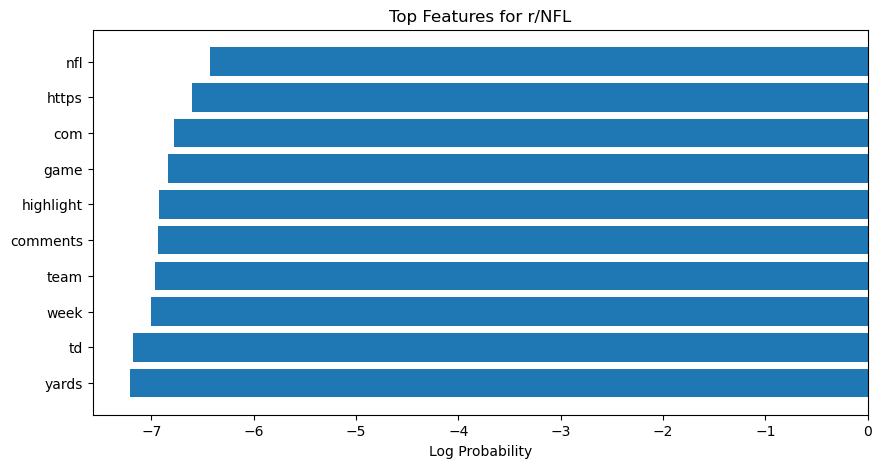

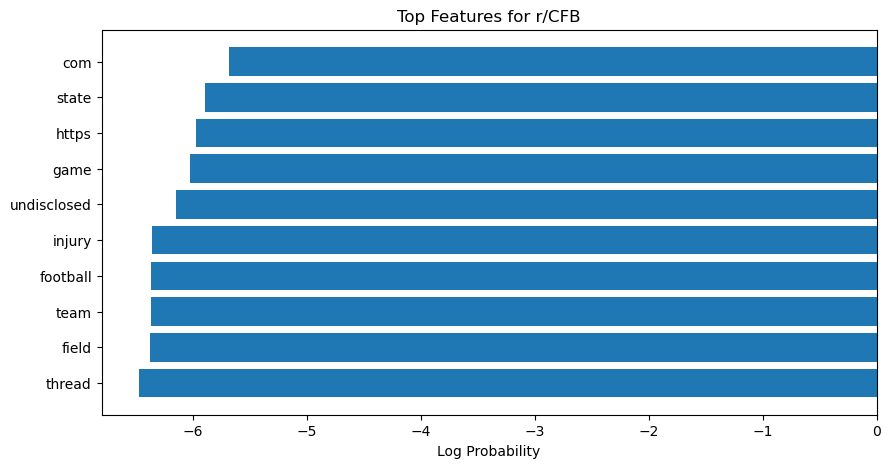

In [256]:
plt.figure(figsize=(10, 5))
plt.barh(top_nfl, log_prob[1][log_prob[1].argsort()[-n_top:]])
plt.title('Top Features for r/NFL')
plt.xlabel('Log Probability')
plt.show()

# For r/CFB
plt.figure(figsize=(10, 5))
plt.barh(top_cfb, log_prob[0][log_prob[0].argsort()[-n_top:]])
plt.title('Top Features for r/CFB')
plt.xlabel('Log Probability')
plt.show()

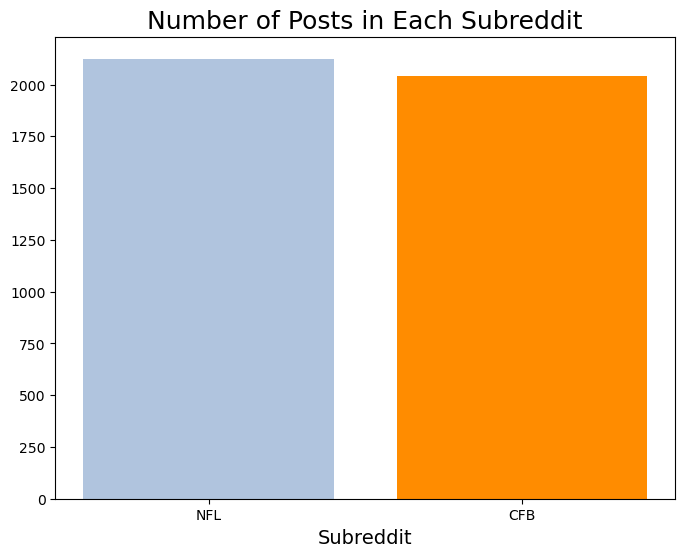

In [170]:
subreddit_counts = posts['subreddit'].str.upper().value_counts()

# Create a bar chart using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(subreddit_counts.index, subreddit_counts.values, color =['lightsteelblue', 'darkorange'])  # Customize colors

# Add labels and title
plt.xlabel('Subreddit', fontsize = 14)
#plt.ylabel('Count of Posts', rotation = 0, ha = 'right', fontsize = 14)
plt.title('Number of Posts in Each Subreddit', fontsize = 18)

# Show the plot
plt.show()

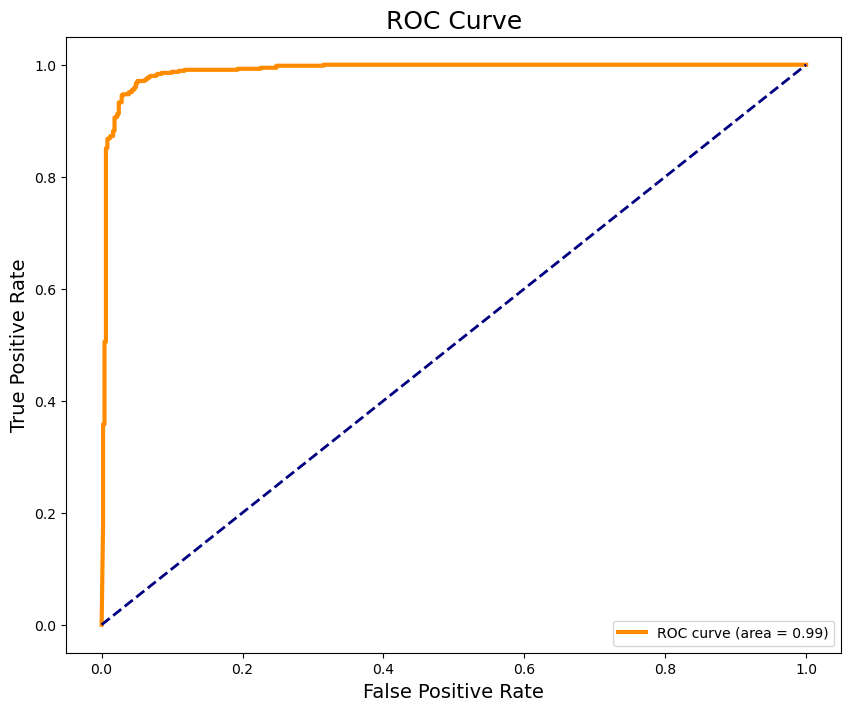

In [178]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probs = gs.predict_proba(posts_concat['text'][y_test.index])[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, _ = roc_curve(y_test, probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC Curve', fontsize = 18)
plt.legend(loc='lower right')
plt.show()